In [1]:
#Standard packages
import numpy as np
import pandas as pd

#Plotting packages
import matplotlib.pyplot as plt


import networkx as nx

import quantstats as qs

In [2]:
df = pd.read_parquet('Stock_price_data.parquet')

df_2 = df.filter(regex=r'Adj Close')

df_2.index = pd.to_datetime(df_2.index)

"""df_2000_2018 = df_2.loc['2000-01-01':'2018-12-31']
df_2019_2023 = df_2.loc['2019-01-01':'2023-12-31']"""


"df_2000_2018 = df_2.loc['2000-01-01':'2018-12-31']\ndf_2019_2023 = df_2.loc['2019-01-01':'2023-12-31']"

In [7]:
def calculate_correlations(df, start_year, end_year):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    
    # Find the first and last trading days within the specified range
    valid_dates = df.loc[start_date:end_date].index
    if not valid_dates.empty:
        start_date = valid_dates[0]
        end_date = valid_dates[-1]
    
    sliced_df = df.loc[start_date:end_date]
    return sliced_df.corr()

def create_correlation_graph(correlations, threshold):
    G = nx.Graph()
    for i in range(correlations.shape[0]):
        for j in range(i + 1, correlations.shape[1]):
            if correlations.iloc[i, j] > threshold:
                G.add_edge(correlations.columns[i], correlations.columns[j])
    return G


def find_independent_nodes(graph):
    independent_nodes = set()

    nodes_sorted_by_degree = sorted(graph.nodes, key=lambda node: graph.degree(node))

    for node in nodes_sorted_by_degree:
        if all(neighbor not in independent_nodes for neighbor in graph.neighbors(node)):
            independent_nodes.add(node)

    return independent_nodes

def rebalance_portfolio(dataframe, start_year, end_year, correlation_years, correlation_threshold):
    portfolio = set()
    num_assets_list=[]
    for year in range(start_year, end_year -correlation_years):
        start_date =year
        end_date = year +correlation_years
        
        correlations = calculate_correlations(dataframe, start_date, end_date)
        
        correlation_graph = create_correlation_graph(correlations, correlation_threshold)
        
        independent_nodes = find_independent_nodes(correlation_graph.copy())
        
        portfolio.update(independent_nodes)

        num_assets_list.append(len(independent_nodes))
    
    mean_num_assets = np.mean(num_assets_list)
    
    return list(portfolio), mean_num_assets

def first_portfolio(dataframe, start_year,  correlation_years, correlation_threshold):

    portfolio = set()

    start_date =start_year
    end_date = start_year+ correlation_years
    
    correlations = calculate_correlations(dataframe, start_date, end_date)
    
    correlation_graph = create_correlation_graph(correlations, correlation_threshold)
    
    independent_nodes = find_independent_nodes(correlation_graph.copy())
    
    portfolio.update(independent_nodes)
    
    return list(portfolio)



### Rebalance of the portfolio

In [8]:

start_year = 2000
end_year = 2018

threshold_array=[0.2,0.3,0.4]
years_array=[1,2,3]

sharpe_ratio_map=[]
num_of_assets_map=[]



for threshold in threshold_array:
    sharpe_ratio_array=[]
    num_of_assets_array=[]
    for years in years_array:
        portfolio, mean_num_assets = rebalance_portfolio(df_2, start_year, end_year, years, threshold)

        portfolio_assets = list(portfolio)
        portfolio_df = df.loc[f"{start_year}-01-01":f"{end_year}-12-31", portfolio_assets]

        returns = portfolio_df.pct_change().dropna().mean(axis=1)
        sharpe_ratio = qs.stats.sharpe(returns)

        annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252 / years)
        
        
        sharpe_ratio_array.append(annualized_sharpe_ratio)
        num_of_assets_array.append(mean_num_assets)

    sharpe_ratio_map.append(sharpe_ratio_array)
    num_of_assets_map.append(num_of_assets_array)

sharpe_ratio_map=np.array(sharpe_ratio_map)
num_of_assets_map=np.array(num_of_assets_map)

np.savetxt('sharpe_ratio_map.txt', sharpe_ratio_map, delimiter=',', fmt='%.2f')
np.savetxt('num_of_assets_map.txt', num_of_assets_map, delimiter=',', fmt='%.2f')




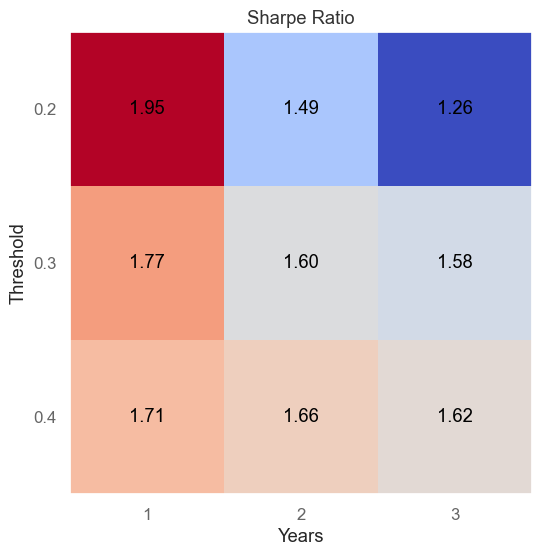

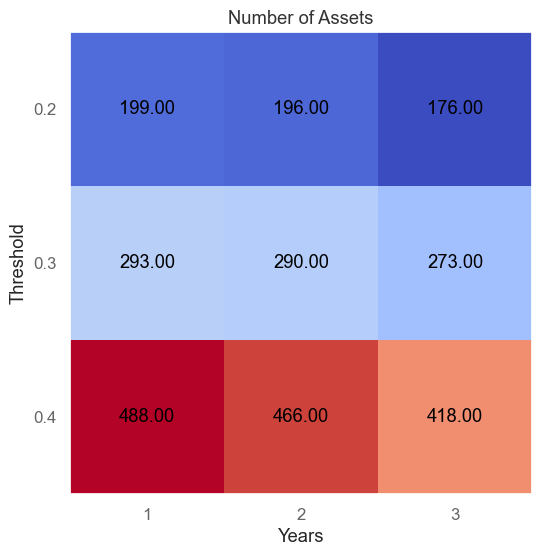

In [16]:

sharpe_ratio_map = np.loadtxt('sharpe_ratio_map.txt', delimiter=',')
num_of_assets_map = np.loadtxt('num_of_assets_map.txt', delimiter=',')

threshold_array = [0.2, 0.3, 0.4]
years_array = [1, 2, 3]

fig, ax = plt.subplots()

cax = ax.imshow(sharpe_ratio_map, cmap='coolwarm')
ax.grid(False)


for i in range(len(threshold_array)):
    for j in range(len(years_array)):
        text = ax.text(j, i, f'{sharpe_ratio_map[i, j]:.2f}', ha='center', va='center', color='black')

ax.set_xticks(np.arange(len(years_array)))
ax.set_yticks(np.arange(len(threshold_array)))
ax.set_xticklabels(years_array)
ax.set_yticklabels(threshold_array)
ax.set_xlabel('Years')
ax.set_ylabel('Threshold')
ax.set_title('Sharpe Ratio')
plt.savefig('sharpe_ratio_map_training.png')

fig, ax = plt.subplots()

cax = ax.imshow(num_of_assets_map, cmap='coolwarm')
ax.grid(False)

for i in range(len(threshold_array)):
    for j in range(len(years_array)):
        text = ax.text(j, i, f'{num_of_assets_map[i, j]:.2f}', ha='center', va='center', color='black')

ax.set_xticks(np.arange(len(years_array)))
ax.set_yticks(np.arange(len(threshold_array)))
ax.set_xticklabels(years_array)
ax.set_yticklabels(threshold_array)
ax.set_xlabel('Years')
ax.set_ylabel('Threshold')
ax.set_title('Number of Assets')
plt.savefig('num_of_assets_map_training.png')


### Optimal case for the Degeneracy ordering portfolio

In [34]:
start_year = 2000
end_year = 2018

def degenarcy_portfolio_cum_returns(df, start_year, end_year, correlation_years, correlation_threshold):

    portfolio, _ = rebalance_portfolio(df_2, start_year, end_year, correlation_years, correlation_threshold)

    portfolio_assets = list(portfolio)
    portfolio_df = df.loc[f"{start_year}-01-01":f"{end_year}-12-31", portfolio_assets]

    daily_returns_degeneracy = portfolio_df.pct_change().dropna()
    cumulative_returns_degeneracy = (1 + daily_returns_degeneracy.mean(axis=1)).cumprod()

    return cumulative_returns_degeneracy

cumulative_returns_degeneracy=degenarcy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.2)

### Equally-Weighted portfolio of the beggining year

In [36]:
def equally_weighted_portfolio_cum_returns(df, start_year, end_year, correlation_years, correlation_threshold):
    portfolio_EW = first_portfolio(df_2, start_year, correlation_years, correlation_threshold)

    portfolio_assets_EW = list(portfolio_EW)
    portfolio_df_EW = df.loc[f"{start_year}-01-01":f"{end_year}-12-31", portfolio_assets_EW]

    num_assets = len(portfolio_df_EW.columns)
    weights = np.array([1 / num_assets] * num_assets)

    daily_returns = portfolio_df_EW.pct_change().dropna()

    equally_weighted_returns = daily_returns.dot(weights)
    equally_weighted_portfolio_df = pd.DataFrame(equally_weighted_returns, columns=['Equally Weighted Returns'])
    cumulative_returns_equally_weighted = (1 + equally_weighted_portfolio_df).cumprod()

    return cumulative_returns_equally_weighted

cumulative_returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year, end_year,1, 0.2)

### Plot of the market, Degenarcy ordering portfolio and Equally-Weighted portfolio

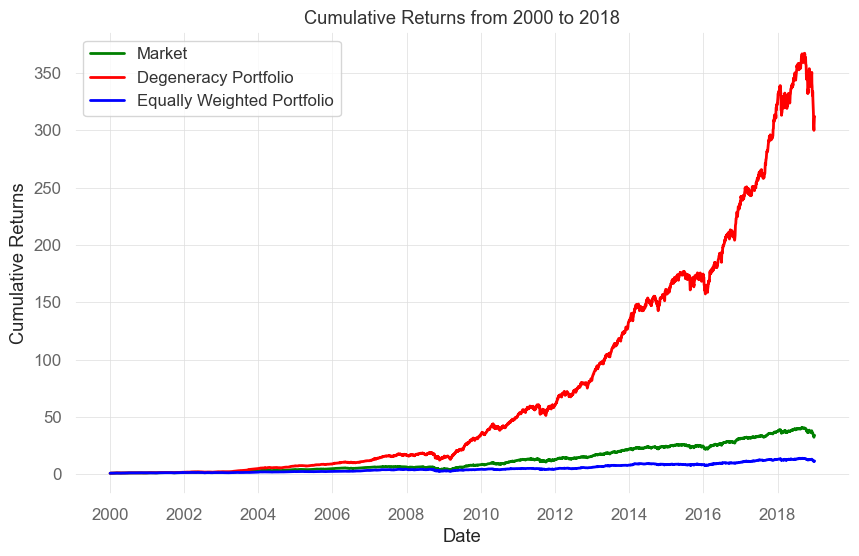

In [38]:
def returns_market(df, start_year, end_year):

    df_filtered = df.loc[f"{start_year}-01-01":f"{end_year}-12-31"]

    daily_returns_all_assets = df_filtered.pct_change().dropna()

    cumulative_returns_market = (1 + daily_returns_all_assets.mean(axis=1)).cumprod()

    return cumulative_returns_market

cumulative_returns_market = returns_market(df_2, start_year, end_year)


def plot_returns(cumulative_returns_market, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, stard_year, end_year):
    plt.figure()

    plt.plot(cumulative_returns_market.index, cumulative_returns_market, label='Market', linewidth=2, color='green')

    plt.plot(cumulative_returns_degeneracy.index, cumulative_returns_degeneracy, label='Degeneracy Portfolio', linewidth=2, color='red')

    plt.plot(cumulative_returns_equally_weighted.index, cumulative_returns_equally_weighted, label='Equally Weighted Portfolio', linewidth=2, color='blue')

    plt.title(f'Cumulative Returns from {stard_year} to {end_year}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)

    plt.savefig(f'cumulative_returns_{stard_year}-{end_year}.png')
    plt.show()

plot_returns(cumulative_returns_market, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, start_year, end_year)


### Test data

In [ ]:
start_year = 2019
end_year = 2023

cumulative_returns_degeneracy=degenarcy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.2)
cumulative_returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.2)
cumulative_returns_market = returns_market(df_2, start_year, end_year)

plot_returns(cumulative_returns_market, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, start_year, end_year)